In [1]:
sf=15

# Install Package

In [1]:
!pip install duckdb --pre --upgrade      > /dev/null 2>&1
!pip install tableauhyperapi             > /dev/null 2>&1
!pip install databend                    > /dev/null 2>&1
!pip install delta-spark                 > /dev/null 2>&1
!pip install pyspark                     > /dev/null 2>&1
!pip show duckdb
!pip show tableauhyperapi
!pip show databend
!pip show pyspark
!pip show delta-spark

Name: duckdb
Version: 0.8.1.dev31
Summary: DuckDB embedded database
Home-page: https://www.duckdb.org
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: 
Name: tableauhyperapi
Version: 0.0.17002
Summary: Hyper API for Python
Home-page: https://tableau.github.io/hyper-db
Author: Salesforce, Inc.
Author-email: tableauhyperapi@tableau.com
License: Proprietary
Location: /usr/local/lib/python3.10/dist-packages
Requires: cffi
Required-by: 
Name: databend
Version: 1.1.43
Summary: 
Home-page: 
Author: Databend Authors <opensource@datafuselabs.com>
Author-email: Databend Authors <opensource@datafuselabs.com>
License: Apache-2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: 
Name: pyspark
Version: 3.3.2
Summary: Apache Spark Python API
Home-page: https://github.com/apache/spark/tree/master/python
Author: Spark Developers
Author-email: dev@spark.apache.org
License: http://www.apache.org/licenses/LICENSE-2.0
Lo

# Generate TPCH Parquet files

In [3]:
%%time
import duckdb
import pathlib
for x in range(0, sf) :
  con=duckdb.connect()
  con.sql('PRAGMA disable_progress_bar;SET preserve_insertion_order=false')
  con.sql(f"CALL dbgen(sf={sf} , children ={sf}, step = {x})") 
  for tbl in ['nation','region','customer','supplier','lineitem','orders','partsupp','part'] :
     pathlib.Path(f'{sf}/{tbl}').mkdir(parents=True, exist_ok=True) 
     con.sql(f"COPY (SELECT * FROM {tbl}) TO '{sf}/{tbl}/{x:02d}.parquet' ")
  con.close()

CPU times: user 10min 25s, sys: 28.6 s, total: 10min 54s
Wall time: 8min 24s


# Load to DuckDB Native Storage

In [2]:
%%time
import duckdb
con = duckdb.connect(f"{sf}/TPCH.DUCKDB")
con.execute(f'''
PRAGMA disable_progress_bar;
CREATE TABLE IF NOT EXISTS  lineitem AS SELECT * FROM '{sf}/lineitem/*.parquet';
CREATE TABLE IF NOT EXISTS  orders AS SELECT * FROM '{sf}/orders/*.parquet';
CREATE TABLE IF NOT EXISTS  partsupp AS SELECT * FROM '{sf}/partsupp/*.parquet';
CREATE TABLE IF NOT EXISTS  part AS SELECT * FROM '{sf}/part/*.parquet';
CREATE TABLE IF NOT EXISTS  supplier AS SELECT * FROM '{sf}/supplier/*.parquet';
CREATE TABLE IF NOT EXISTS  nation AS SELECT * FROM '{sf}/nation/*.parquet';
CREATE TABLE IF NOT EXISTS  region AS SELECT * FROM '{sf}/region/*.parquet';
CREATE TABLE IF NOT EXISTS  customer AS SELECT * FROM '{sf}/customer/*.parquet';
''')
con.close()

CPU times: user 7min 3s, sys: 24.1 s, total: 7min 27s
Wall time: 4min 59s


# Load to Hyper Native Storage

In [3]:
# GENERATE EMPTY HYPER FILE, probabaly there is a better way
from tableauhyperapi import HyperProcess, Telemetry, Connection, CreateMode, NOT_NULLABLE, NULLABLE, \
SqlType, TableDefinition, Inserter, escape_name, escape_string_literal, HyperException, TableName
with HyperProcess(telemetry=Telemetry.SEND_USAGE_DATA_TO_TABLEAU) as hyper:
         with Connection(endpoint=hyper.endpoint, database=f"{sf}/tpch.hyper",create_mode=CreateMode.CREATE_AND_REPLACE) as connection:
             connection.execute_query('SELECT 42')

In [2]:
from tableauhyperapi import HyperProcess, Telemetry, Connection, CreateMode, NOT_NULLABLE, NULLABLE, \
SqlType, TableDefinition, Inserter, escape_name, escape_string_literal, HyperException, TableName
def hypersql(sql) :
   with HyperProcess(telemetry=Telemetry.SEND_USAGE_DATA_TO_TABLEAU) as hyper:
         with Connection(endpoint=hyper.endpoint, database=f"{sf}/tpch.hyper",create_mode=CreateMode.NONE) as connection:
             data= connection.execute_list_query(sql)
             df = pd.DataFrame.from_records(data)
             print(df)

In [5]:
%%time
#load data into hyper
import pandas as pd
import shutil
for tbl in ['nation','region','customer','supplier','lineitem','orders','partsupp','part'] :
  array_list_ls =[f" '{sf}/{tbl}/{x:02d}.parquet' " for x in range(0, sf) ]
  array_list =", ".join(array_list_ls)
  hypersql(f""" create table "{tbl}" as (select * from external(array[{array_list}])) """)

/usr/local/lib/python3.10/dist-packages/tableauhyperapi/result.py:462: UnclosedObjectWarning: Result has not been closed. Use Result object in a with statement or call its close() method when done.
  warnings.warn('Result has not been closed. Use Result object in a with statement or call its close() '


Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
CPU times: user 2.38 s, sys: 261 ms, total: 2.64 s
Wall time: 5min 27s


# Load data to Databend

In [3]:
from databend import SessionContext
import os
ctx_bend = SessionContext("TPCH")

In [7]:
%%time
pwd = os.getcwd()
for tbl in ['nation','region','customer','supplier','lineitem','orders','partsupp','part'] :
    ctx_bend.sql(f"""drop table IF EXISTS {tbl}""").collect()
    print(f" create {tbl}")
    ctx_bend.sql(f"""CREATE TABLE IF NOT EXISTS {tbl} AS SELECT * FROM 'fs://{pwd}/{sf}/{tbl}/' (pattern => '.*.parquet' ) """).collect()
    ctx_bend.sql(f"""analyze table {tbl}""").collect()
    print(ctx_bend.sql(f"""select count(1) from  {tbl}""").collect())

 create nation
┌──────────┐
│ count(1) │
│  UInt64  │
├──────────┤
│       25 │
└──────────┘
 create region
┌──────────┐
│ count(1) │
│  UInt64  │
├──────────┤
│        5 │
└──────────┘
 create customer
┌──────────┐
│ count(1) │
│  UInt64  │
├──────────┤
│  2250000 │
└──────────┘
 create supplier
┌──────────┐
│ count(1) │
│  UInt64  │
├──────────┤
│   150000 │
└──────────┘
 create lineitem
┌──────────┐
│ count(1) │
│  UInt64  │
├──────────┤
│ 89987373 │
└──────────┘
 create orders
┌──────────┐
│ count(1) │
│  UInt64  │
├──────────┤
│ 22500000 │
└──────────┘
 create partsupp
┌──────────┐
│ count(1) │
│  UInt64  │
├──────────┤
│ 12000000 │
└──────────┘
 create part
┌──────────┐
│ count(1) │
│  UInt64  │
├──────────┤
│  3000000 │
└──────────┘
CPU times: user 8min 21s, sys: 36.5 s, total: 8min 57s
Wall time: 5min 42s


# Load to Spark (Delta Table)

In [8]:
import pyspark
from delta import *
builder = pyspark.sql.SparkSession.builder.appName("MyApp") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
spark = configure_spark_with_delta_pip(builder).getOrCreate()

In [9]:
%%time
for tbl in ['nation','region','customer','supplier','lineitem','orders','partsupp','part'] :
   spark.read.parquet(f'{sf}/{tbl}/*.parquet').createOrReplaceTempView(f'{tbl}_view')
   spark.sql(f""" CREATE OR REPLACE TABLE delta.`/content/delta/{tbl}` USING DELTA AS SELECT * FROM {tbl}_view  """)

CPU times: user 5.09 s, sys: 879 ms, total: 5.97 s
Wall time: 14min 3s


# Run Benchmarks

In [2]:
sql=(f'''
SELECT
    --Query01
    l_returnflag,
    l_linestatus,
    SUM(l_quantity) AS sum_qty,
    SUM(l_extendedprice) AS sum_base_price,
    SUM(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
    SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
    AVG(l_quantity) AS avg_qty,
    AVG(l_extendedprice) AS avg_price,
    AVG(l_discount) AS avg_disc,
    COUNT(*) AS count_order
FROM
    lineitem
WHERE
    l_shipdate <= CAST('1998-09-02' AS date)
GROUP BY
    l_returnflag,
    l_linestatus
ORDER BY
    l_returnflag,
    l_linestatus;

    
SELECT
    --Query02
    s_acctbal,
    s_name,
    n_name,
    p_partkey,
    p_mfgr,
    s_address,
    s_phone,
    s_comment
FROM
    part,
    supplier,
    partsupp,
    nation,
    region
WHERE
    p_partkey = ps_partkey
    AND s_suppkey = ps_suppkey
    AND p_size = 15
    AND p_type LIKE '%BRASS'
    AND s_nationkey = n_nationkey
    AND n_regionkey = r_regionkey
    AND r_name = 'EUROPE'
    AND ps_supplycost = (
        SELECT
            MIN(ps_supplycost)
        FROM
            partsupp,
            supplier,
            nation,
            region
        WHERE
            p_partkey = ps_partkey
            AND s_suppkey = ps_suppkey
            AND s_nationkey = n_nationkey
            AND n_regionkey = r_regionkey
            AND r_name = 'EUROPE'
    )
ORDER BY
    s_acctbal DESC,
    n_name,
    s_name,
    p_partkey
LIMIT
    100;







SELECT
    --Query03
    l_orderkey,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue,
    o_orderdate,
    o_shippriority
FROM
    customer,
    orders,
    lineitem
WHERE
    c_mktsegment = 'BUILDING'
    AND c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND o_orderdate < CAST('1995-03-15' AS date)
    AND l_shipdate > CAST('1995-03-15' AS date)
GROUP BY
    l_orderkey,
    o_orderdate,
    o_shippriority
ORDER BY
    revenue DESC,
    o_orderdate
LIMIT
    10;


    





SELECT
    --Query04
    o_orderpriority,
    COUNT(*) AS order_count
FROM
    orders
WHERE
    o_orderdate >= CAST('1993-07-01' AS date)
    AND o_orderdate < CAST('1993-10-01' AS date)
    AND EXISTS (
        SELECT
            *
        FROM
            lineitem
        WHERE
            l_orderkey = o_orderkey
            AND l_commitdate < l_receiptdate
    )
GROUP BY
    o_orderpriority
ORDER BY
    o_orderpriority;


    





SELECT
    --Query05
    n_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue
FROM
    customer,
    orders,
    lineitem,
    supplier,
    nation,
    region
WHERE
    c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND l_suppkey = s_suppkey
    AND c_nationkey = s_nationkey
    AND s_nationkey = n_nationkey
    AND n_regionkey = r_regionkey
    AND r_name = 'ASIA'
    AND o_orderdate >= CAST('1994-01-01' AS date)
    AND o_orderdate < CAST('1995-01-01' AS date)
GROUP BY
    n_name
ORDER BY
    revenue DESC;


    




SELECT
    --Query06
    SUM(l_extendedprice * l_discount) AS revenue
FROM
    lineitem
WHERE
    l_shipdate >= CAST('1994-01-01' AS date)
    AND l_shipdate < CAST('1995-01-01' AS date)
    AND l_discount BETWEEN 0.05
    AND 0.07
    AND l_quantity < 24;


    




SELECT
    --Query07
    supp_nation,
    cust_nation,
    l_year,
    SUM(volume) AS revenue
FROM
    (
        SELECT
            n1.n_name AS supp_nation,
            n2.n_name AS cust_nation,
            EXTRACT(
                year
                FROM
                    l_shipdate
            ) AS l_year,
            l_extendedprice * (1 - l_discount) AS volume
        FROM
            supplier,
            lineitem,
            orders,
            customer,
            nation n1,
            nation n2
        WHERE
            s_suppkey = l_suppkey
            AND o_orderkey = l_orderkey
            AND c_custkey = o_custkey
            AND s_nationkey = n1.n_nationkey
            AND c_nationkey = n2.n_nationkey
            AND (
                (
                    n1.n_name = 'FRANCE'
                    AND n2.n_name = 'GERMANY'
                )
                OR (
                    n1.n_name = 'GERMANY'
                    AND n2.n_name = 'FRANCE'
                )
            )
            AND l_shipdate BETWEEN CAST('1995-01-01' AS date)
            AND CAST('1996-12-31' AS date)
    ) AS shipping
GROUP BY
    supp_nation,
    cust_nation,
    l_year
ORDER BY
    supp_nation,
    cust_nation,
    l_year;


    




SELECT
    --Query08
    o_year,
    SUM(
        CASE
            WHEN nation = 'BRAZIL' THEN volume
            ELSE 0
        END
    ) / SUM(volume) AS mkt_share
FROM
    (
        SELECT
            EXTRACT(
                year
                FROM
                    o_orderdate
            ) AS o_year,
            l_extendedprice * (1 - l_discount) AS volume,
            n2.n_name AS nation
        FROM
            part,
            supplier,
            lineitem,
            orders,
            customer,
            nation n1,
            nation n2,
            region
        WHERE
            p_partkey = l_partkey
            AND s_suppkey = l_suppkey
            AND l_orderkey = o_orderkey
            AND o_custkey = c_custkey
            AND c_nationkey = n1.n_nationkey
            AND n1.n_regionkey = r_regionkey
            AND r_name = 'AMERICA'
            AND s_nationkey = n2.n_nationkey
            AND o_orderdate BETWEEN CAST('1995-01-01' AS date)
            AND CAST('1996-12-31' AS date)
            AND p_type = 'ECONOMY ANODIZED STEEL'
    ) AS all_nations
GROUP BY
    o_year
ORDER BY
    o_year;


    







SELECT
    --Query09
    nation,
    o_year,
    SUM(amount) AS sum_profit
FROM
    (
        SELECT
            n_name AS nation,
            EXTRACT(
                year
                FROM
                    o_orderdate
            ) AS o_year,
            l_extendedprice * (1 - l_discount) - ps_supplycost * l_quantity AS amount
        FROM
            part,
            supplier,
            lineitem,
            partsupp,
            orders,
            nation
        WHERE
            s_suppkey = l_suppkey
            AND ps_suppkey = l_suppkey
            AND ps_partkey = l_partkey
            AND p_partkey = l_partkey
            AND o_orderkey = l_orderkey
            AND s_nationkey = n_nationkey
            AND p_name LIKE '%green%'
    ) AS profit
GROUP BY
    nation,
    o_year
ORDER BY
    nation,
    o_year DESC;


    





SELECT
    --Query10
    c_custkey,
    c_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue,
    c_acctbal,
    n_name,
    c_address,
    c_phone,
    c_comment
FROM
    customer,
    orders,
    lineitem,
    nation
WHERE
    c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND o_orderdate >= CAST('1993-10-01' AS date)
    AND o_orderdate < CAST('1994-01-01' AS date)
    AND l_returnflag = 'R'
    AND c_nationkey = n_nationkey
GROUP BY
    c_custkey,
    c_name,
    c_acctbal,
    c_phone,
    n_name,
    c_address,
    c_comment
ORDER BY
    revenue DESC
LIMIT
    20;







SELECT
    --Query11
    ps_partkey,
    SUM(ps_supplycost * ps_availqty) AS value
FROM
    partsupp,
    supplier,
    nation
WHERE
    ps_suppkey = s_suppkey
    AND s_nationkey = n_nationkey
    AND n_name = 'GERMANY'
GROUP BY
    ps_partkey
HAVING
    SUM(ps_supplycost * ps_availqty) > (
        SELECT
            SUM(ps_supplycost * ps_availqty) * (0.0001/{sf})
            -- SUM(ps_supplycost * ps_availqty) * 1
        FROM
            partsupp,
            supplier,
            nation
        WHERE
            ps_suppkey = s_suppkey
            AND s_nationkey = n_nationkey
            AND n_name = 'GERMANY'
    )
ORDER BY
    value DESC;


    





SELECT
    --Query12
    l_shipmode,
    SUM(
        CASE
            WHEN o_orderpriority = '1-URGENT'
            OR o_orderpriority = '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS high_line_count,
    SUM(
        CASE
            WHEN o_orderpriority <> '1-URGENT'
            AND o_orderpriority <> '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS low_line_count
FROM
    orders,
    lineitem
WHERE
    o_orderkey = l_orderkey
    AND l_shipmode IN ('MAIL', 'SHIP')
    AND l_commitdate < l_receiptdate
    AND l_shipdate < l_commitdate
    AND l_receiptdate >= CAST('1994-01-01' AS date)
    AND l_receiptdate < CAST('1995-01-01' AS date)
GROUP BY
    l_shipmode
ORDER BY
    l_shipmode;


    





SELECT
    --Query13
    c_count,
    COUNT(*) AS custdist
FROM
    (
        SELECT
            c_custkey,
            COUNT(o_orderkey) AS c_count
        FROM
            customer
            LEFT OUTER JOIN orders ON c_custkey = o_custkey
            AND o_comment NOT LIKE '%special%requests%'
        GROUP BY
            c_custkey
    ) AS c_orders
GROUP BY
    c_count
ORDER BY
    custdist DESC,
    c_count DESC;


    





SELECT
    --Query14
    100.00 * SUM(
        CASE
            WHEN p_type LIKE 'PROMO%' THEN l_extendedprice * (1 - l_discount)
            ELSE 0
        END
    ) / SUM(l_extendedprice * (1 - l_discount)) AS promo_revenue
FROM
    lineitem,
    part
WHERE
    l_partkey = p_partkey
    AND l_shipdate >= date '1995-09-01'
    AND l_shipdate < CAST('1995-10-01' AS date);


    





SELECT
    --Query15
    s_suppkey,
    s_name,
    s_address,
    s_phone,
    total_revenue
FROM
    supplier,
    (
        SELECT
            l_suppkey AS supplier_no,
            SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
        FROM
            lineitem
        WHERE
            l_shipdate >= CAST('1996-01-01' AS date)
            AND l_shipdate < CAST('1996-04-01' AS date)
        GROUP BY
            supplier_no
    ) revenue0
WHERE
    s_suppkey = supplier_no
    AND total_revenue = (
        SELECT
            MAX(total_revenue)
        FROM
            (
                SELECT
                    l_suppkey AS supplier_no,
                    SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
                FROM
                    lineitem
                WHERE
                    l_shipdate >= CAST('1996-01-01' AS date)
                    AND l_shipdate < CAST('1996-04-01' AS date)
                GROUP BY
                    l_suppkey
            ) revenue1
    )
ORDER BY
    s_suppkey;


    





SELECT
    --Query16
    p_brand,
    p_type,
    p_size,
    COUNT(DISTINCT ps_suppkey) AS supplier_cnt
FROM
    partsupp,
    part
WHERE
    p_partkey = ps_partkey
    AND p_brand <> 'Brand#45'
    AND p_type NOT LIKE 'MEDIUM POLISHED%'
    AND p_size IN (
        49,
        14,
        23,
        45,
        19,
        3,
        36,
        9
    )
    AND ps_suppkey NOT IN (
        SELECT
            s_suppkey
        FROM
            supplier
        WHERE
            s_comment LIKE '%Customer%Complaints%'
    )
GROUP BY
    p_brand,
    p_type,
    p_size
ORDER BY
    supplier_cnt DESC,
    p_brand,
    p_type,
    p_size;


    





SELECT
    --Query17
    SUM(l_extendedprice) / 7.0 AS avg_yearly
FROM
    lineitem,
    part
WHERE
    p_partkey = l_partkey
    AND p_brand = 'Brand#23'
    AND p_container = 'MED BOX'
    AND l_quantity < (
        SELECT
            0.2 * AVG(l_quantity)
        FROM
            lineitem
        WHERE
            l_partkey = p_partkey
    );
    





SELECT
    --Query18
    c_name,
    c_custkey,
    o_orderkey,
    o_orderdate,
    o_totalprice,
    SUM(l_quantity)
FROM
    customer,
    orders,
    lineitem
WHERE
    o_orderkey IN (
        SELECT
            l_orderkey
        FROM
            lineitem
        GROUP BY
            l_orderkey
        HAVING
            SUM(l_quantity) > 300
    )
    AND c_custkey = o_custkey
    AND o_orderkey = l_orderkey
GROUP BY
    c_name,
    c_custkey,
    o_orderkey,
    o_orderdate,
    o_totalprice
ORDER BY
    o_totalprice DESC,
    o_orderdate
LIMIT
    100;
    




SELECT
    --Query19
    SUM(l_extendedprice * (1 - l_discount)) AS revenue
FROM
    lineitem,
    part
WHERE
    (
        p_partkey = l_partkey
        AND p_brand = 'Brand#12'
        AND p_container IN (
            'SM CASE',
            'SM BOX',
            'SM PACK',
            'SM PKG'
        )
        AND l_quantity >= 1
        AND l_quantity <= 1 + 10
        AND p_size BETWEEN 1
        AND 5
        AND l_shipmode IN ('AIR', 'AIR REG')
        AND l_shipinstruct = 'DELIVER IN PERSON'
    )
    OR (
        p_partkey = l_partkey
        AND p_brand = 'Brand#23'
        AND p_container IN (
            'MED BAG',
            'MED BOX',
            'MED PKG',
            'MED PACK'
        )
        AND l_quantity >= 10
        AND l_quantity <= 10 + 10
        AND p_size BETWEEN 1
        AND 10
        AND l_shipmode IN ('AIR', 'AIR REG')
        AND l_shipinstruct = 'DELIVER IN PERSON'
    )
    OR (
        p_partkey = l_partkey
        AND p_brand = 'Brand#34'
        AND p_container IN (
            'LG CASE',
            'LG BOX',
            'LG PACK',
            'LG PKG'
        )
        AND l_quantity >= 20
        AND l_quantity <= 20 + 10
        AND p_size BETWEEN 1
        AND 15
        AND l_shipmode IN ('AIR', 'AIR REG')
        AND l_shipinstruct = 'DELIVER IN PERSON'
    );
    





SELECT
    --Query20
    s_name,
    s_address
FROM
    supplier,
    nation
WHERE
    s_suppkey IN (
        SELECT
            ps_suppkey
        FROM
            partsupp
        WHERE
            ps_partkey IN (
                SELECT
                    p_partkey
                FROM
                    part
                WHERE
                    p_name LIKE 'forest%'
            )
            AND ps_availqty > (
                SELECT
                    0.5 * SUM(l_quantity)
                FROM
                    lineitem
                WHERE
                    l_partkey = ps_partkey
                    AND l_suppkey = ps_suppkey
                    AND l_shipdate >= CAST('1994-01-01' AS date)
                    AND l_shipdate < CAST('1995-01-01' AS date)
            )
    )
    AND s_nationkey = n_nationkey
    AND n_name = 'CANADA'
ORDER BY
    s_name;
    





SELECT
    --Query21
    s_name,
    COUNT(*) AS numwait
FROM
    supplier,
    lineitem l1,
    orders,
    nation
WHERE
    s_suppkey = l1.l_suppkey
    AND o_orderkey = l1.l_orderkey
    AND o_orderstatus = 'F'
    AND l1.l_receiptdate > l1.l_commitdate
    AND EXISTS (
        SELECT
            *
        FROM
            lineitem l2
        WHERE
            l2.l_orderkey = l1.l_orderkey
            AND l2.l_suppkey <> l1.l_suppkey
    )
    AND NOT EXISTS (
        SELECT
            *
        FROM
            lineitem l3
        WHERE
            l3.l_orderkey = l1.l_orderkey
            AND l3.l_suppkey <> l1.l_suppkey
            AND l3.l_receiptdate > l3.l_commitdate
    )
    AND s_nationkey = n_nationkey
    AND n_name = 'SAUDI ARABIA'
GROUP BY
    s_name
ORDER BY
    numwait DESC,
    s_name
LIMIT
    100;
    





SELECT
    --Query22
    cntrycode,
    COUNT(*) AS numcust,
    SUM(c_acctbal) AS totacctbal
FROM
    (
        SELECT
            SUBSTRING(c_phone, 1, 2) AS cntrycode,
            c_acctbal
        FROM
            customer
        WHERE
            SUBSTRING(c_phone, 1, 2) IN (
                '13',
                '31',
                '23',
                '29',
                '30',
                '18',
                '17'
            )
            AND c_acctbal > (
                SELECT
                    AVG(c_acctbal)
                FROM
                    customer
                WHERE
                    c_acctbal > 0.00
                    AND SUBSTRING(c_phone, 1, 2) IN (
                        '13',
                        '31',
                        '23',
                        '29',
                        '30',
                        '18',
                        '17'
                    )
            )
            AND NOT EXISTS (
                SELECT
                    *
                FROM
                    orders
                WHERE
                    o_custkey = c_custkey
            )
    ) AS custsale
GROUP BY
    cntrycode
ORDER BY
    cntrycode;
    
''')

**Databend**

In [6]:
import time
import pandas as pd
def execute_query(engine, sql_script):
    df = pd.DataFrame(columns=['dur'])
    sql_arr = sql_script.split(";")
    for index, value in enumerate(sql_arr,start=1):
        if len(value.strip()) > 0:
            start = time.time()
            print('Query' + str(index))
            try : 
             xx=engine.sql(value).collect()
             print(xx)
             stop = time.time()
             duration = stop-start
            except  Exception as er:
              print(er)
              duration =0
            print(duration)
            row = {'dur': duration}
            df = pd.concat([df,pd.DataFrame(row, index=[index])], axis=0, ignore_index=True)
    return df 
databend = execute_query(ctx_bend, sql)
if not os.path.exists(os.getcwd() + '/' + 'result'):
    os.makedirs(os.getcwd() + '/' + 'result', exist_ok=True) 
databend.to_csv ('./result/databend.csv', index = None, header=True) 

Query1
┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ l_returnflag │ l_linestatus │       sum_qty       │    sum_base_price   │    sum_disc_price   │      sum_charge      │       avg_qty       │      avg_price      │       avg_disc      │ count_order │
│  String NULL │  String NULL │ Decimal(38, 2) NULL │ Decimal(38, 2) NULL │ Decimal(38, 4) NULL │  Decimal(38, 6) NULL │ Decimal(38, 4) NULL │ Decimal(38, 4) NULL │ Decimal(38, 4) NULL │    UInt64   │
├──────────────┼──────────────┼─────────────────────┼─────────────────────┼─────────────────────┼──────────────────────┼─────────────────────┼─────────────────────┼─────────────────────┼─────────────┤
│ 'A'          │ 'F'          │ 566283055.00        │ 849177085010.41     │ 806712460771.8161   │ 838987609469.975561  │ 25.5010             │ 38240.4885          │ 0.0500              │   

**Duckdb**

In [4]:
import time
import duckdb
import os
import pandas as pd
pd.set_option('display.max_columns', 20)
def execute_query(engine, sql_script):
    df = pd.DataFrame(columns=['dur'])
    sql_arr = sql_script.split(";")
    for index, value in enumerate(sql_arr,start=1):
        if len(value.strip()) > 0:
            start = time.time()
            print('Query' + str(index))
            try : 
             engine.sql(value).show()
             stop = time.time()
             duration = stop-start
            except  Exception as er:
              print(er)
              duration =0
            print(duration)
            row = {'dur': duration}
            df = pd.concat([df,pd.DataFrame(row, index=[index])], axis=0, ignore_index=True)
    return df 
con = duckdb.connect(f"{sf}/TPCH.DUCKDB",read_only=True)
con.execute('''
PRAGMA disable_progress_bar;
PRAGMA enable_object_cache
''')
duck_import=execute_query(con, sql)
con.close()
if not os.path.exists(os.getcwd() + '/' + 'result'):
    os.makedirs(os.getcwd() + '/' + 'result', exist_ok=True) 
duck_import.to_csv ('./result/duckdb.csv', index = None, header=True)

Query1
┌──────────────┬──────────────┬───────────────┬───┬────────────────────┬──────────────────────┬─────────────┐
│ l_returnflag │ l_linestatus │    sum_qty    │ … │     avg_price      │       avg_disc       │ count_order │
│   varchar    │   varchar    │ decimal(38,2) │   │       double       │        double        │    int64    │
├──────────────┼──────────────┼───────────────┼───┼────────────────────┼──────────────────────┼─────────────┤
│ A            │ F            │  566283055.00 │ … │  38240.48859308446 │ 0.050007286693869245 │    22206230 │
│ N            │ F            │   14778119.00 │ … │ 38249.238348227314 │ 0.049949334562842236 │      579093 │
│ N            │ O            │ 1114934274.00 │ … │  38231.79480757481 │ 0.049996511942548866 │    43726344 │
│ R            │ F            │  566531511.00 │ … │  38250.75477878017 │  0.05000362045786973 │    22209898 │
├──────────────┴──────────────┴───────────────┴───┴────────────────────┴──────────────────────┴─────────────┤
│ 4

**Hyper**

In [6]:
import time
import pandas as pd
from tableauhyperapi import HyperProcess, Telemetry, Connection, CreateMode, NOT_NULLABLE, NULLABLE, \
SqlType, TableDefinition, Inserter, escape_name, escape_string_literal, HyperException, TableName
def hypersql(sql) :
   with HyperProcess(telemetry=Telemetry.SEND_USAGE_DATA_TO_TABLEAU) as hyper:
         with Connection(endpoint=hyper.endpoint, database=f"{sf}/tpch.hyper",create_mode=CreateMode.NONE) as connection:
             data= connection.execute_list_query(sql)
             df = pd.DataFrame.from_records(data)
             print(df)
pd.set_option('display.max_columns', 20)
def run_query( sql_script):
    df = pd.DataFrame(columns=['dur'])
    sql_arr = sql_script.split(";")
    for index, value in enumerate(sql_arr,start=1):
        if len(value.strip()) > 0:
            start = time.time()
            print('Query' + str(index))
            try : 
             hypersql(value)
             stop = time.time()
             duration = stop-start
            except  Exception as er:
              print(er)
              duration =0
            print(duration)
            row = {'dur': duration}
            df = pd.concat([df,pd.DataFrame(row, index=[index])], axis=0, ignore_index=True)
    return df   
hyper= run_query(sql)
if not os.path.exists(os.getcwd() + '/' + 'result'):
    os.makedirs(os.getcwd() + '/' + 'result', exist_ok=True) 
hyper.to_csv ('./result/hyper.csv', index = None, header=True)  

Query1
   0  1              2                 3                   4  \
0  A  F   566283055.00   849177085010.41   806712460771.8161   
1  N  F    14778119.00    22149866182.79    21042683937.6224   
2  N  O  1114934274.00  1671736611493.43  1588151460665.7231   
3  R  F   566531511.00   849545362059.72   807067445047.2249   

                    5      6         7     8         9  
0   838987608707.3986   25.5  38240.49  0.05  22206230  
1    21885945944.1287  25.52  38249.24  0.05    579093  
2  1651689982963.1861   25.5  38231.79  0.05  43726344  
3   839352013779.6292  25.51  38250.75  0.05  22209898  
13.554071426391602
Query2
          0                   1               2        3               4  \
0   9999.65  Supplier#000143654          FRANCE  1606143  Manufacturer#2   
1   9994.66  Supplier#000071807          FRANCE    34306  Manufacturer#3   
2   9993.32  Supplier#000119310          FRANCE   494303  Manufacturer#4   
3   9990.13  Supplier#000138240          FRANCE  1225715 

**Apache Spark**

In [8]:
import time
import duckdb
import pandas as pd
import pyspark
from delta import *
builder = pyspark.sql.SparkSession.builder.appName("MyApp") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
spark = configure_spark_with_delta_pip(builder).getOrCreate()
pd.set_option('display.max_columns', 20)
def execute_query(engine, sql_script):
    df = pd.DataFrame(columns=['dur'])
    sql_arr = sql_script.split(";")
    for index, value in enumerate(sql_arr,start=1):
        if len(value.strip()) > 0:
            start = time.time()
            print('Query' + str(index))
            try : 
             engine.sql(value).show()
             stop = time.time()
             duration = stop-start
            except  Exception as er:
              print(er)
              duration =0
            print(duration)
            row = {'dur': duration}
            df = pd.concat([df,pd.DataFrame(row, index=[index])], axis=0, ignore_index=True)
    return df 
for tbl in ['nation','region','customer','supplier','lineitem','orders','partsupp','part'] :
   spark.read.format("delta").load(f"/content/delta/{tbl}").createOrReplaceTempView(f'{tbl}')
apachespark = execute_query(spark, sql)
if not os.path.exists(os.getcwd() + '/' + 'result'):
    os.makedirs(os.getcwd() + '/' + 'result', exist_ok=True) 
apachespark.to_csv ('./result/spark.csv', index = None, header=True)

Query1
+------------+------------+-------------+----------------+------------------+--------------------+---------+------------+--------+-----------+
|l_returnflag|l_linestatus|      sum_qty|  sum_base_price|    sum_disc_price|          sum_charge|  avg_qty|   avg_price|avg_disc|count_order|
+------------+------------+-------------+----------------+------------------+--------------------+---------+------------+--------+-----------+
|           A|           F| 566283055.00| 849177085010.41| 806712460771.8161| 838987609469.975561|25.501089|38240.488593|0.050007|   22206230|
|           N|           F|  14778119.00|  22149866182.79|  21042683937.6224|  21885945964.070341|25.519423|38249.238348|0.049949|     579093|
|           N|           O|1114934274.00|1671736611493.43|1588151460665.7231|1651689984464.620841|25.497999|38231.794808|0.049997|   43726344|
|           R|           F| 566531511.00| 849545362059.72| 807067445047.2249| 839352014542.078408|25.508065|38250.754779|0.050004|   22

# Result

In [10]:
import numpy as np
duck_import    = pd.read_csv('./result/duckdb.csv')
hyper          = pd.read_csv('./result/hyper.csv')
databend       = pd.read_csv('./result/databend.csv')
apachespark    = pd.read_csv('./result/spark.csv')


duck_import['query'] = duck_import.index
hyper['query'] = hyper.index
apachespark['query'] = apachespark.index
databend['query'] = databend.index
con1=duckdb.connect()
concat = con1.sql('''select  duck_import.dur as DuckDB ,
 hyper.dur as hyper ,
 databend.dur as databend ,
 apachespark.dur as apachespark
 from duck_import
left join hyper
on duck_import.query=hyper.query
left join databend
on duck_import.query=databend.query
left join apachespark
on duck_import.query=apachespark.query
''').df()
concat.index = np.arange(1, len(concat)+1)
concat

,DuckDB,hyper,databend,apachespark
1,18.302773,13.554071,40.575886,264.111648
2,1.292284,2.809267,3.800531,54.778109
3,3.219560,8.800784,18.667231,104.902292
4,5.647291,2.872949,10.467764,75.362193
5,3.162460,7.229873,20.063927,156.477390
6,0.962956,0.960975,15.178442,11.600600
7,10.224020,3.687430,20.065605,128.182522
8,2.516785,2.253956,14.871400,41.923702
9,17.785137,14.575317,34.919634,111.078925
10,6.219103,5.608748,20.101676,70.773817


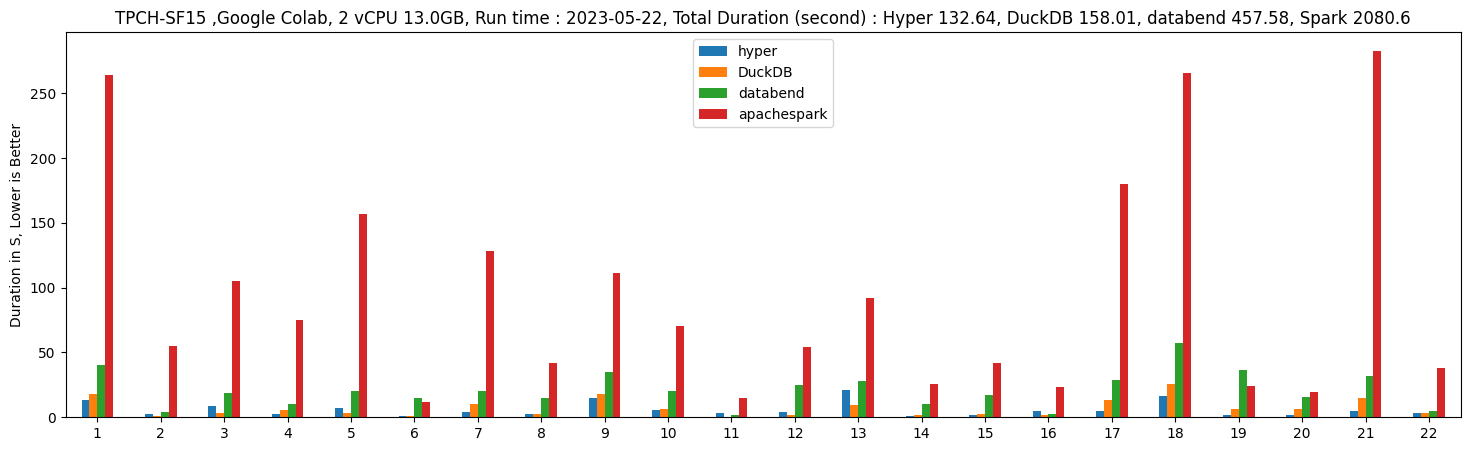

In [11]:
result = concat[['hyper','DuckDB','databend','apachespark']]
from psutil import *
vCPU = str(cpu_count()) + " vCPU"
mem=round(virtual_memory().total/(1024 * 1024 * 1024),0)
runtime = 'TPCH-SF'+str(sf)+' ,Google Colab, '+vCPU+' '+str(mem)+'GB, Run time : '+ str(time.strftime("%Y-%m-%d")) \
+ ', Total Duration (second) : Hyper '+str(round(result['hyper'].sum(),2))\
+', DuckDB '+str(round(result['DuckDB'].sum(),2)) \
+', databend '+str(round(result['databend'].sum(),2))\
+', Spark '+str(round(result['apachespark'].sum(),2))
ax = result.plot.bar(rot=0,title=runtime,ylabel='Duration in S, Lower is Better',figsize=(18,5))